In [401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report , confusion_matrix , roc_curve , roc_auc_score 
from sklearn import metrics

In [402]:
white = pd.read_csv('datasets/winequality-white.csv' , delimiter = ';')
red = pd.read_csv('datasets/winequality-red.csv' , delimiter = ';')

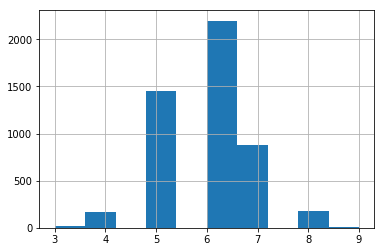

In [403]:
white['quality'].hist()

In [404]:
for i in range(len(white)):
    if white['quality'].iloc[i] == 3 or white['quality'].iloc[i] == 4  :
        white['quality'].iloc[i] = 0
    if  white['quality'].iloc[i] == 6 or white['quality'].iloc[i] == 5 :
        white['quality'].iloc[i] = 1
    if white['quality'].iloc[i] == 7 or white['quality'].iloc[i] == 8 or white['quality'].iloc[i] == 9 :
        white['quality'].iloc[i] = 2

In [405]:
X_White = white.drop('quality', axis = 1).values
y_White = white['quality'].values

In [406]:
X_White_train, X_White_test, y_White_train, y_White_test = train_test_split(X_White , y_White  , test_size = 0.2 , random_state = 42)

In [407]:
def calculate_and_plot_k_neighbors(X_train, X_test, y_train, y_test):
    
    neighbors = np.arange(1, 15)
    train_accuracy = np.empty(len(neighbors))
    test_accuracy = np.empty(len(neighbors))
    
    for i, k in enumerate(neighbors):
        knn = KNeighborsClassifier(n_neighbors= k)
        knn.fit(X_train , y_train)
        train_accuracy[i] = knn.score(X_train, y_train)    
        test_accuracy[i] = knn.score(X_test, y_test)
        
    plt.title('k in kNN analysis')
    plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
    plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
    plt.legend()
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.show()

In [408]:
def kNN_algorithm(X_train, X_test, y_train, y_test , k):
    
    global y_pred_kNN
    global kNN_pipeline
    
    steps = [('impute' , SimpleImputer(missing_values = 0, strategy='mean')),
             ('sclaer', StandardScaler()),
             ('kNN', KNeighborsClassifier(n_neighbors = k))]
    
    kNN_pipeline = Pipeline(steps)
    
    kNN_pipeline.fit(X_train , y_train)
    
    y_pred_kNN = kNN_pipeline.predict(X_test)
    
    print(classification_report(y_test , y_pred_kNN))
    print('kNN algorithm acuracy is : {0:.2f} %'.format(kNN_pipeline.score(X_test , y_test) * 100))

In [409]:
def SVM_algorithm(X_train, X_test, y_train, y_test):
    
    global y_pred_SVM
    global SVM_pipeline
    global y_prob_SVM
    
    steps = [('scaler', StandardScaler()),
             ('SVM', SVC(probability=True))]
    
    SVM_pipeline = Pipeline(steps)
    
    parameters = {'SVM__C':[1, 10, 100 , 1000],
                  'SVM__gamma':[0.1, 0.01 , 0.001]}
    
    cv = GridSearchCV(SVM_pipeline , param_grid = parameters)
    
    cv.fit(X_train , y_train)
    
    y_pred_SVM = cv.predict(X_test)
    
    y_prob_SVM = cv.predict_proba(X_test)
    
    print("Accuracy: {0:.2f} %".format(cv.score(X_test, y_test) * 100))
    print(classification_report(y_test, y_pred_SVM))
    print("Tuned Model Parameters: {}".format(cv.best_params_))

In [410]:
def plot_confusion_matrix(cf_matrix , y_test , model_type , cf_size):
    if cf_size == '2x2':
        group_names = ['True Negative','False Positive','False Negative','True Positive']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = ['{}\n{}'.format(v1 ,v2) for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)
        plt.figure(figsize=(8, 5))
        sns.heatmap(
            cf_matrix,
            annot = labels,
            cmap=sns.cubehelix_palette(100, as_cmap=True, hue=1, dark=0.30),
            fmt='',
            linewidths=1.5,
            vmin=0,
            vmax=len(y_test),
        )
        plt.title(model_type)
        plt.show()
    else:
        plt.figure(figsize=(8, 5))
        sns.heatmap(
            cf_matrix,
            annot = True,
            cmap=sns.cubehelix_palette(100, as_cmap=True, hue=1, dark=0.30),
            fmt='',
            linewidths=1.5,
            vmin=0,
            vmax=len(y_test),
        )
        plt.title(model_type)
        plt.show()

In [411]:
def plot_AUC_ROC_kNN(X_test , y_test , pipeline):
    
    probs = pipeline.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = {0:.2f}'.format(roc_auc_score(y_test, preds)))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    print('ROC AUC score is ' + '{0:.2f}'.format(roc_auc_score(y_test, preds)))

In [412]:
def plot_AUC_ROC_SVM(X_test , y_test , y_prob_SVM):
    
    probs = y_prob_SVM
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = {0:.2f}'.format(roc_auc_score(y_test, preds)))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    print('ROC AUC score is ' + '{0:.2f}'.format(roc_auc_score(y_test, preds)))

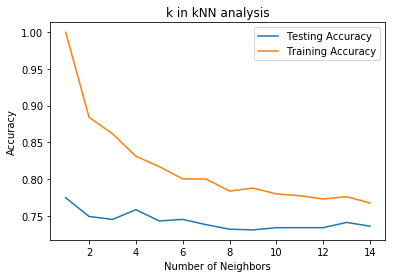

In [413]:
calculate_and_plot_k_neighbors(X_White_train, X_White_test, y_White_train, y_White_test)

In [415]:
kNN_algorithm(X_White_train, X_White_test, y_White_train, y_White_test , 1)

              precision    recall  f1-score   support

           0       0.29      0.33      0.31        30
           1       0.88      0.87      0.88       723
           2       0.70      0.72      0.71       227

   micro avg       0.82      0.82      0.82       980
   macro avg       0.63      0.64      0.63       980
weighted avg       0.82      0.82      0.82       980

kNN algorithm acuracy is : 82.04 %


In [416]:
cf_matrix_knn = confusion_matrix(y_White_test, y_pred_kNN)

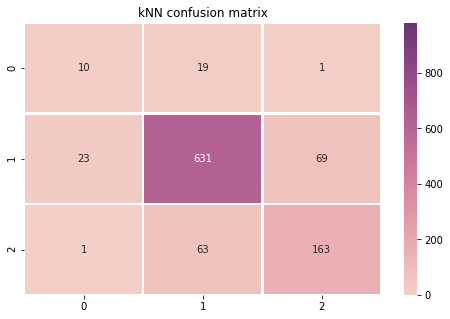

In [417]:
plot_confusion_matrix(cf_matrix_knn , y_White_test , 'kNN confusion matrix' , '3x3')

In [418]:
SVM_algorithm(X_White_train, X_White_test, y_White_train, y_White_test)

Accuracy: 81.02 %
              precision    recall  f1-score   support

           0       0.47      0.23      0.31        30
           1       0.83      0.93      0.88       723
           2       0.73      0.49      0.59       227

   micro avg       0.81      0.81      0.81       980
   macro avg       0.68      0.55      0.59       980
weighted avg       0.80      0.81      0.79       980

Tuned Model Parameters: {'SVM__C': 10, 'SVM__gamma': 0.1}


In [419]:
cf_matrix_SVM = confusion_matrix(y_White_test, y_pred_SVM)

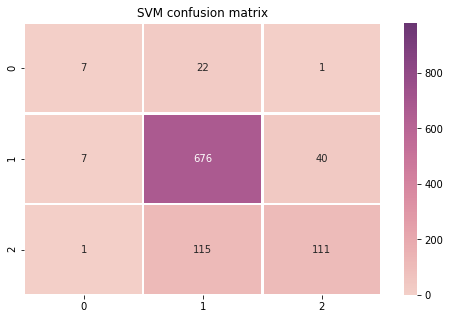

In [420]:
plot_confusion_matrix(cf_matrix_SVM , y_White_test , 'SVM confusion matrix' , '3x3')

In [421]:
#End of the white wine

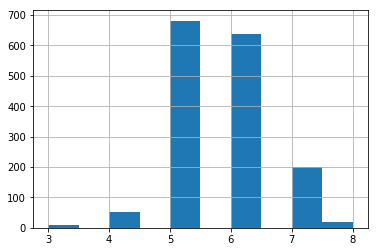

In [422]:
red['quality'].hist()

In [423]:
for i in range(len(red)):
    if red['quality'].iloc[i] == 3 or red['quality'].iloc[i] == 4 or red['quality'].iloc[i] == 5 :
        red['quality'].iloc[i] = 0
    if  red['quality'].iloc[i] == 6 or red['quality'].iloc[i] == 7 or red['quality'].iloc[i] == 8 :
        red['quality'].iloc[i] = 1

In [424]:
X_Red = red.drop('quality', axis = 1).values
y_Red = red['quality'].values

In [425]:
X_Red_train, X_Red_test, y_Red_train, y_Red_test = train_test_split(X_Red , y_Red  , test_size = 0.3 , random_state = 42)

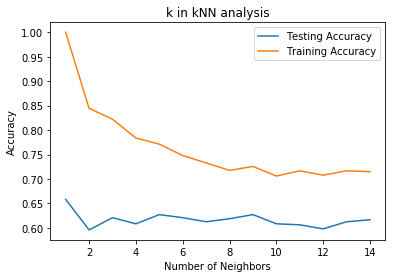

In [426]:
calculate_and_plot_k_neighbors(X_Red_train, X_Red_test, y_Red_train, y_Red_test)

In [427]:
kNN_algorithm(X_Red_train, X_Red_test, y_Red_train, y_Red_test , 1)

              precision    recall  f1-score   support

           0       0.74      0.67      0.70       213
           1       0.76      0.81      0.78       267

   micro avg       0.75      0.75      0.75       480
   macro avg       0.75      0.74      0.74       480
weighted avg       0.75      0.75      0.75       480

kNN algorithm acuracy is : 74.79 %


In [428]:
cf_matrix_knn_red = confusion_matrix(y_Red_test, y_pred_kNN)

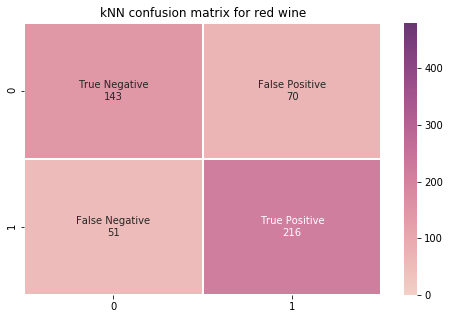

In [429]:
plot_confusion_matrix(cf_matrix_knn_red , y_Red_test , 'kNN confusion matrix for red wine' , '2x2')

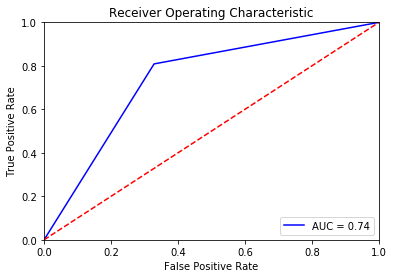

ROC AUC score is 0.74


In [430]:
plot_AUC_ROC_kNN(X_Red_test , y_Red_test , kNN_pipeline)

In [431]:
SVM_algorithm(X_Red_train, X_Red_test, y_Red_train, y_Red_test)

Accuracy: 75.83 %
              precision    recall  f1-score   support

           0       0.71      0.77      0.74       213
           1       0.80      0.75      0.78       267

   micro avg       0.76      0.76      0.76       480
   macro avg       0.76      0.76      0.76       480
weighted avg       0.76      0.76      0.76       480

Tuned Model Parameters: {'SVM__C': 100, 'SVM__gamma': 0.01}


In [432]:
cf_matrix_SVM_red = confusion_matrix(y_Red_test,y_pred_SVM)

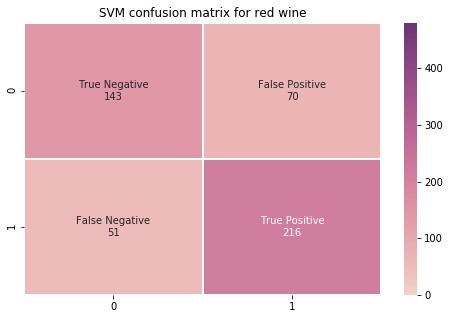

In [433]:
plot_confusion_matrix(cf_matrix_knn_red , y_Red_test , 'SVM confusion matrix for red wine' , '2x2')

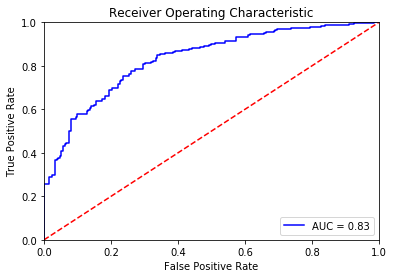

ROC AUC score is 0.83


In [434]:
plot_AUC_ROC_SVM(X_Red_test , y_Red_test , y_prob_SVM)